# Climate Change


“Some say climate change is the biggest threat of our age while others say it’s a myth based on dodgy science”. 

The objective of the project is to analyze the pattern in the various aspects of climatic systems to provide evidence about the climatic changes, a top concern in today’s fast-developing world. The plan is to collect the data of some of the top factors contributing to the change in climate. This includes the factors like rising temperatures, increase in the sea levels, rise in air pollution, etc. While there are many independent submissions that address these issues, there is a need for a consolidated view which connects all these factors. The project endeavors to answer some of the concerning questions with the data. 


### Import the necessary Libraries

In [1]:
import sqlite3 as sq
import pandas as pd
import csv
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = 'D:/Deep Learning/Softwares/Anaconda/envs/sirajology/lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap

### Create connection to sqlite3 database

In [2]:
db_file = 'Climate.db'
conn = sq.connect(db_file)
# conn.close()
c=conn.cursor()

### Load the datasets into tables 

We start by reading the sql queries from file.

In [ ]:
def create_tables_from_file():
    with open('create_tables.sql','r') as f:
        for query in f:
            c.execute(query)

        
#create_tables_from_file()

# Note: Remove the above comment and run the function only if you want to create fresh tables
# If the connection to the database is established and the database already has the required tables, then no need to run this cell

Next step is to insert the records from the csv files into their respective tables

In [ ]:
def insert_records():
    datasets = ['GlobalLandTemperaturesByCountry.csv',
                'GlobalLandTemperaturesByCity.csv',
                'GlobalTemperatures.csv',
                'GlobalLandTemperaturesByState.csv',
                'GlobalLandTemperaturesByMajorCity.csv']
    
    #datasets = ['GlobalLandTemperaturesByMajorCity.csv']
    
    for dataset in datasets:
        
        if dataset == 'GlobalLandTemperaturesByCity.csv':
            f= open(dataset,'r',encoding="utf8")
        else:
            f= open(dataset,'r')
            
        
        data = csv.DictReader(f)
        
        if dataset == 'GlobalLandTemperaturesByCountry.csv':
            to_db = [(i['dt'], i['AverageTemperature'],i['AverageTemperatureUncertainty'],i['Country']) for i in data]
            query = "INSERT INTO COUNTRY (DATE, AVG_TEMP,AVG_TEMP_UNC,COUNTRY) VALUES (?,?,?,?);"
        
        elif dataset == 'GlobalLandTemperaturesByCity.csv':
            to_db = [(i['dt'], i['AverageTemperature'],i['AverageTemperatureUncertainty'],i['City'],i['Country'],i['Latitude'],i['Longitude']) for i in data]
            query = "INSERT INTO CITY (DATE, AVG_TEMP,AVG_TEMP_UNC,CITY,COUNTRY,LATITUDE,LONGITUDE) VALUES (?, ?,?,?,?,?,?);"
        
        elif dataset == 'GlobalTemperatures.csv':
            to_db = [(i['dt'], i['LandAverageTemperature'],i['LandAverageTemperatureUncertainty'],i['LandMaxTemperature'],i['LandMaxTemperatureUncertainty'],i['LandMinTemperature'],i['LandMinTemperatureUncertainty'],i['LandAndOceanAverageTemperature'],i['LandAndOceanAverageTemperatureUncertainty']) for i in data]
            query = "INSERT INTO GLOBAL_TEMP (DATE,LAND_AVG_TEMP,LAND_AVG_TEMP_UNC,LAND_MAX_TEMP,LAND_MAX_UNC,LAND_MIN_TEMP,LAND_MIN_UNC,LAND_OC_TEMP,LAND_OC_UNC) VALUES (?, ?,?,?,?,?,?,?,?);"
        
        elif dataset == 'GlobalLandTemperaturesByState.csv':
            to_db = [(i['dt'], i['AverageTemperature'],i['AverageTemperatureUncertainty'],i['State'],i['Country']) for i in data]
            query = "INSERT INTO STATE (DATE,AVG_TEMP,AVG_TEMP_UNC,STATE,COUNTRY) VALUES (?, ?,?,?,?);"
        
        elif dataset == 'GlobalLandTemperaturesByMajorCity.csv':
            to_db = [(i['dt'], i['AverageTemperature'],i['AverageTemperatureUncertainty'],i['City'],i['Country'],i['Latitude'],i['Longitude']) for i in data]
            query = "INSERT INTO MAJOR_CITY (DATE,AVG_TEMP,AVG_TEMP_UNC,CITY,COUNTRY,LATITUDE,LONGITUDE) VALUES (?, ?,?,?,?,?,?);"
            
 
        c.executemany(query, to_db)
        conn.commit()
        f.close()        
            

#insert_records()

# NOTE: Remove the above comment and run the function only if you want to insert tables into records
# If the connection to the database is established and the database already has the required tables, then no need to run this cell

In [3]:
#sanity check (database connectivity check)
c.execute('select count(*) from GLOBAL_TEMP')
rows = c.fetchall()
print(rows)

[(3192,)]


In [4]:
# Record counts in each table(or dataset)
c.execute('select count(*) from COUNTRY')
rows = c.fetchall()
print(rows)
c.execute('select count(*) from CITY')
rows = c.fetchall()
print(rows)
c.execute('select count(*) from GLOBAL_TEMP')
rows = c.fetchall()
print(rows)
c.execute('select count(*) from STATE')
rows = c.fetchall()
print(rows)
c.execute('select count(*) from MAJOR_CITY')
rows = c.fetchall()
print(rows)

[(577462,)]
[(8599212,)]
[(3192,)]
[(645675,)]
[(239177,)]


## Visualizations

### Is the temperature really increasing ??

Let's take a look at the Global temperatures over the years.

Create a dataframe with average global temperature over the years.

In [5]:
query1 = """SELECT strftime('%Y',DATE)Year, AVG(LAND_AVG_TEMP) LandAverageTemperature
            FROM GLOBAL_TEMP
            WHERE LAND_AVG_TEMP != ''
            GROUP BY Year"""
df1 = pd.read_sql(query1, con = conn)

query2="""SELECT strftime('%Y',DATE)Year,AVG(LAND_OC_TEMP) LandOceanAverageTemperature
            FROM GLOBAL_TEMP
            WHERE LAND_OC_TEMP != ''
            GROUP BY Year"""

df2 = pd.read_sql(query2, con = conn)
# df1.head(5)
# df2.head(5)

In [6]:
Land_avg=go.Scatter(x=df1['Year'],y=df1['LandAverageTemperature'],mode='lines',name='Land_avg')
Land_ocean_avg=go.Scatter(x=df2['Year'],y=df2['LandOceanAverageTemperature'],mode='lines',name='Land_ocean_avg')
data1=[Land_avg]
data2=[Land_ocean_avg]
layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Land Temperature, °C'),
    title='Average Land Temperature in World',
    showlegend = True)

fig1 = go.Figure(data=data1, layout=layout)
py.iplot(fig1);
layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Land-Ocean Temperature, °C'),
    title='Average Land-Ocean Temperature in World',
    showlegend = True)

fig2 = go.Figure(data=data2, layout=layout)
py.iplot(fig2);

Land temperature & Land-Ocean Temperature does appear to be increasing over the years

In [7]:
query1 = """SELECT strftime('%Y',DATE)Year, AVG(LAND_AVG_TEMP) LandAverageTemperature, AVG(LAND_AVG_TEMP_UNC) LandAverageTemperatureUncertainity
            FROM GLOBAL_TEMP
            WHERE LAND_AVG_TEMP != ''
            GROUP BY Year"""
df = pd.read_sql(query1, con = conn)
df.head(5)
trace0 = go.Scatter(
    x = df['Year'], 
    y = np.array(df['LandAverageTemperature']) + np.array(df['LandAverageTemperatureUncertainity']),
    fill= None,
    mode='lines',
    name='Uncertainty top',
    line=dict(
        color='rgb(225,0,0 )',
    )
)
trace1 = go.Scatter(
    x = df['Year'], 
    y = np.array(df['LandAverageTemperature']) - np.array(df['LandAverageTemperatureUncertainity']),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(
        color='rgb(255, 0, 0)',
    )
)
trace2 = go.Scatter(
    x = df['Year'], 
    y = df['LandAverageTemperature'],
    name='Average Temperature',
    line=dict(
        color='rgb(1, 1, 1)',
    )
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig);

From the plot it can be seen that there is global warming (increase in the average Land Temperature). The average temperature of Earth surface has highest value in the last three centuries. The fastest temperature increase was observed in the last 30 years! The plots also show confidence intervals, which shows that measurement of temperature has become more accurate in the last few years.

#### How do the average temperatures in the world look like ?

In [8]:

query1 = """SELECT AVG(AVG_TEMP),COUNTRY FROM COUNTRY GROUP BY COUNTRY"""
df_country = pd.read_sql(query1, con = conn)

data = [ dict(
        type = 'choropleth',
        locations = df_country['COUNTRY'],
        z = df_country['AVG(AVG_TEMP)'],
        locationmode = 'country names',
        text = df_country['COUNTRY'],
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]

layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap');

Note: The Globe can be moved around to view temperatures in every country.

#### Which country has seen the maximum temperature change in the last 100 years ?

In [11]:
query = """SELECT A.COUNTRY,A.average_temp-B.average_temp as TempChange
            FROM 
            (
                SELECT MAX(strftime('%Y',DATE)) Year,AVG(AVG_TEMP) average_temp, COUNTRY
                FROM COUNTRY
                WHERE AVG_TEMP != ''
                GROUP BY COUNTRY
            ) A,
            (
                SELECT strftime('%Y',DATE) Year, AVG(AVG_TEMP) average_temp, COUNTRY
                FROM COUNTRY
                WHERE AVG_TEMP != ''
                AND Year = '1900'
                GROUP BY COUNTRY
            ) B
            where A.COUNTRY = B.COUNTRY
            group by A.COUNTRY
            order by TempChange desc
            LIMIT 30
        """
df = pd.read_sql(query, con = conn)
df.head(3)

,COUNTRY,TempChange
0,Finland,1.244242
1,Sweden,1.050915
2,Norway,1.025887


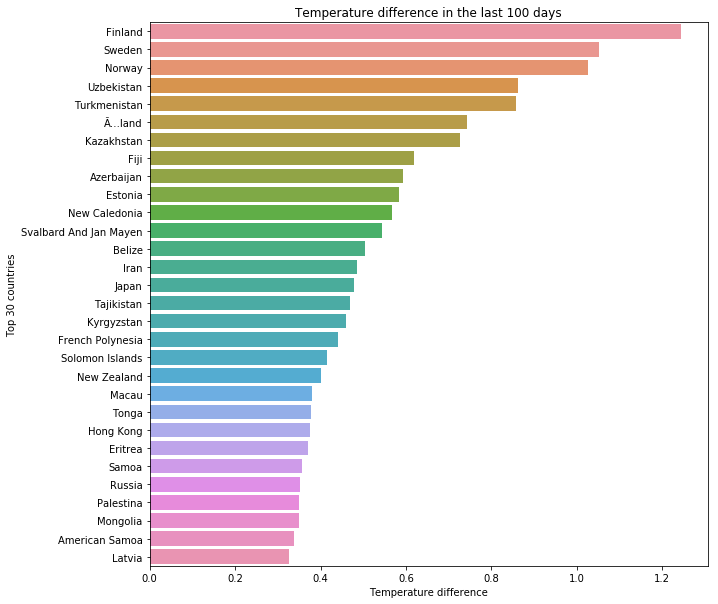

In [12]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=df['TempChange'], y=df['COUNTRY'], ax=ax);
texts = ax.set(ylabel="Top 30 countries", xlabel="Temperature difference", title="Temperature difference in the last 100 days")



#### Average Temperature in United States 

In [13]:
query1 = """SELECT AVG(AVG_TEMP),STATE FROM STATE Where COUNTRY=='United States' GROUP BY STATE """
df_state = pd.read_sql(query1, con = conn)

dummy=['Alabama', 'AL','Alaska', 'AK','Arizona', 'AZ','Arkansas', 'AR','California', 'CA','Colorado', 'CO'
,'Connecticut', 'CT','Delaware', 'DE','District Of Columbia', 'DC','Florida', 'FL','Georgia (State)', 'GA','Hawaii', 'HI'
,'Idaho', 'ID','Illinois', 'IL','Indiana', 'IN','Iowa', 'IA','Kansas', 'KS','Kentucky', 'KY'
,'Louisiana', 'LA','Maine', 'ME','Maryland', 'MD','Massachusetts', 'MA','Michigan', 'MI'
,'Minnesota', 'MN','Mississippi', 'MS','Missouri', 'MO','Montana', 'MT','Nebraska', 'NE','Nevada', 'NV','New Hampshire', 'NH','New Jersey', 'NJ'
,'New Mexico', 'NM','New York', 'NY','North Carolina', 'NC','North Dakota', 'ND'
,'Ohio', 'OH','Oklahoma', 'OK','Oregon', 'OR','Pennsylvania', 'PA','Rhode Island', 'RI'
,'South Carolina', 'SC','South Dakota', 'SD','Tennessee', 'TN','Texas', 'TX'
,'Utah', 'UT','Vermont', 'VT','Virginia', 'VA','Washington', 'WA'
,'West Virginia', 'WV','Wisconsin', 'WI','Wyoming', 'WY']

code=dummy[1::2]
# len(code)
data = [ dict(
        type = 'choropleth',
        colorscale='Viridis',
        autocolorscale= False,
        locations = code,
        z = df_state['AVG(AVG_TEMP)'],
        locationmode = 'USA-states',
        text = df_state['STATE'],
        marker = dict(
            line = dict(color = 'rgb(255,255,255)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]

layout = dict(
    title = 'Average land temperature for USA',
    geo = dict(
        scope='usa',
        showframe = False,
        showlakes = False,
        oceancolor = 'rgb(255,255,255)',
        projection = dict(
        type = 'albers usa')
            
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='d3-cloropleth-map');

#### How Temperature has changed over the years in United States

In [14]:


query1 = """SELECT strftime('%Y',DATE)Year, AVG_TEMP, STATE
            FROM STATE
            WHERE AVG_TEMP != '' and COUNTRY== 'United States'
            GROUP BY Year,STATE"""
import plotly.express as px
df_United_states=pd.read_sql(query1, con = conn)

fig = px.scatter(df_United_states, x="Year", y="AVG_TEMP", color="STATE",trendline="OLS")
fig.show();



#### Moving down to New York...

Text(0,0.5,'Temperature in degree centigrade')

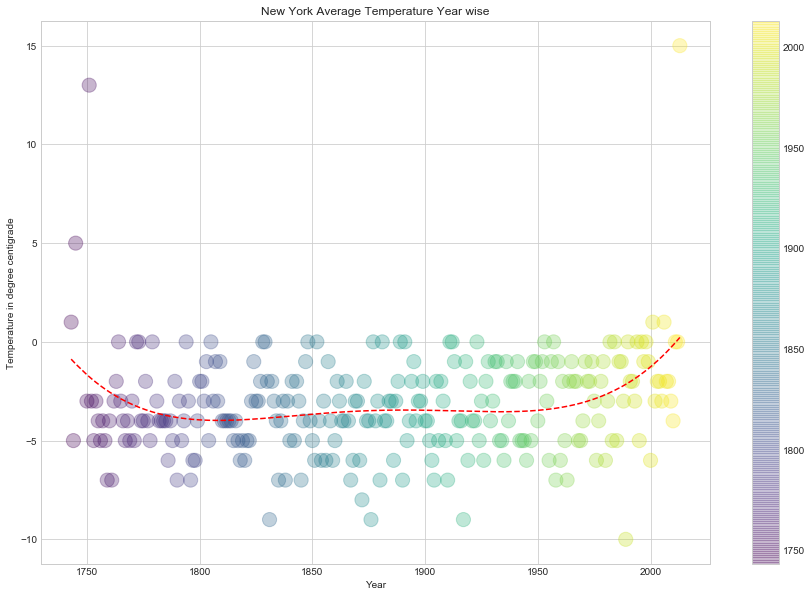

In [15]:
query1 = """SELECT strftime('%Y',DATE)Year, AVG_TEMP, STATE
            FROM STATE
            WHERE AVG_TEMP != '' and STATE== 'New York'
            GROUP BY Year"""
df = pd.read_sql(query1, con = conn)


df.head(5)
plt.figure(figsize=(15,10))
plt.style.use('seaborn-whitegrid')
# rng = np.random.RandomState(0)
x =[int(i) for i in df['Year']] 
y = [int(i) for i in df['AVG_TEMP']]
colors = [int(i) for i in df['Year']]


plt.scatter(x, y, c=colors, s=200, alpha=0.3,
            cmap='viridis')
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
plt.plot(x,p(x),"r--");
plt.colorbar();
plt.title("New York Average Temperature Year wise")
plt.xlabel("Year")
plt.ylabel("Temperature in degree centigrade")

###  Conclusion: 

Climate change is REAL
There has been drastic increase in land temperatures in last 50 years around the world. 
The Scandanevian countries are affected the most due to rising temperatures.
Temperature fluctuations are more in recent years. This confirms that the signs and cautions presented in the news are true!

The accuracy and precision of measurement of temperature has been greatly improved over the years.

Global warming is the increase in the average temperature of the Earth's near-surface air and oceans since the mid-20th century and its projected continuation. Global surface temperature increased 0.74 ± 0.18 °C (1.33 ± 0.32 °F) during the last century. The Intergovernmental Panel on Climate Change (IPCC) concludes that increasing greenhouse gas concentrations resulting from human activity such as fossil fuel burning and deforestation are responsible for most of the observed temperature increase since the middle of the 20th century. The IPCC also concludes that variations in natural phenomena such as solar radiation and volcanoes produced most of the warming from pre-industrial times to 1950 and had a small cooling effect afterward. These basic conclusions have been endorsed by more than 45 scientific societies and academies of science, including all of the national academies of science of the major industrialized countries.
Climate model projections summarized in the latest IPCC report indicate that the global surface temperature will probably rise a further 1.1 to 6.4 °C (2.0 to 11.5 °F) during the twenty-first century. The uncertainty in this estimate arises from the use of models with differing sensitivity to greenhouse gas concentrations and the use of differing estimates of future greenhouse gas emissions. Some other uncertainties include how warming and related changes will vary from region to region around the globe. Most studies focus on the period up to the year 2100. However, warming is expected to continue beyond 2100 even if emissions stop, because of the large heat capacity of the oceans and the long lifetime of carbon dioxide in the atmosphere.
An increase in global temperature will cause sea levels to rise and will change the amount and pattern of precipitation, probably including expansion of subtropical deserts. The continuing retreat of glaciers, permafrost and sea ice is expected, with warming being strongest in the Arctic. Other likely effects include increases in the intensity of extreme weather events, species extinctions, and changes in agricultural yields.
Political and public debate continues regarding climate change, and what actions (if any) to take in response. The available options are mitigation to reduce further emissions; adaptation to reduce the damage caused by warming; and, more speculatively, geoengineering to reverse global warming. Most national governments have signed and ratified the Kyoto Protocol aimed at reducing greenhouse gas emissions. A small number of scientists dispute the consensus on global warming science.
 - physics.org

In [ ]:
conn.close()